In [88]:
import networkx as nx
import sqlite3
import pandas as pd
import numpy as np

class WorkflowViz:
    def __init__(self,state_viz=None):
        self.state_idx = {}
        if state_viz != None:
            self.state_viz = state_viz
            self.refresh_state(state)
        else:
            self.state_viz = []
        self._relation = set()
        self.relation = []

    def add_state(self,step,step_id):
        self.state_viz.append(StateViz(step,[],step_id=step_id))
        self.refresh_state()

    def refresh_state(self):
        for i,x in enumerate(self.state_viz):
            self.state_idx[x.step] = i

    def get_state(self,state):
        return self.state_viz[self.state_idx[state]]

    def add_relation(self,input_step,input_col,output_step,output_col,relation):
        if (input_step,input_col,output_step,output_col,relation) not in self._relation:
            self._relation.add((input_step,input_col,output_step,output_col,relation))
            self.relation.append(RelationViz(input_step,input_col,output_step,output_col,relation))
        #self.get_state(input_step).get_data(input_col).next = self.get_state(output_step).get_data(output_col)
        #self.get_state(output_step).get_data(output_col).prev = self.get_state(input_step).get_data(input_col)

class RelationViz:
    def __init__(self,input_step,input_col,output_step,output_col,relation):
        #self.input_data = None
        #self.output_data = None
        #self.relation = None        
        self.add_relation(input_step,input_col,output_step,output_col,relation)

    def add_relation(self,input_step,input_col,output_step,output_col,relation):
        #self.input_data = self.get_state(input_step).get_data(input_col)
        #self.output_data = self.get_state(output_step).get_data(output_col)
        self.relation = relation
        self.input_step = input_step
        self.input_col = input_col
        self.output_step = output_step
        self.output_col = output_col
        

class StateViz:
    def __init__(self,step,data_list,step_id=None):
        self.step = step
        self.step_id = step_id
        self.col_idx = {}
        self.data_list = data_list
        self.refresh_index()
        #for i,x in enumerate(self.data_list):
        #    self.col_idx[x.col_id] = i
    
    def get_data(self,col_id):
        return self.data_list[self.col_idx[col_id]]

    def add_data(self,col_id,col_name,row=None,value=None,is_used=False):
        self.data_list.append(DataViz(col_id,col_name,row,value,is_used))

    def refresh_index(self):
        for i,x in enumerate(self.data_list):
            self.col_idx[x.col_id] = i

class DataViz:
    def __init__(self,col_id,col_name,row=None,value=None,is_used=False):
        self.col_id = col_id
        self.col_name = col_name
        self.row = row
        self.value = value
        self.next = set()
        self.prev = set()
        self.is_used = is_used


class ProvenanceExplorer:    
    def __init__(self,dbfile):
        self.dbfile = dbfile
        #self.conn = sqlite3.connect(self.dbfile)
        #self.cursor = self.conn.cursor()
        self.open_connection()

    def open_connection(self):
        self.conn = sqlite3.connect(self.dbfile)
        self.cursor = self.conn.cursor()
    
    def close_connection(self):
        self.conn.close()

    def get_number_of_state(self):
        return pd.read_sql_query("""
        SELECT max(state_id) as num_state FROM state 
        """, self.conn)

    def get_changes_each_state(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])
        return pd.read_sql_query("""
        SELECT (state_id-(select max(state_id)+1 from state s))*-1 as state,substr(command,33) as operation,col_id,count(1) as cell_changes FROM state 
        NATURAL JOIN content NATURAL JOIN value  NATURAL JOIN cell NATURAL JOIN state_command
        where state in ({state})
        group by state,col_id
        order by state asc        
        """.format(state=state), self.conn)

    def get_column_at_state(self,state):
        """
        col_at_state = list(self.cursor.execute("select * from col_each_state where state={}".format(state)))
        names = list(map(lambda x: x[0], self.cursor.description))   
        table_dict = {}
        for x in names:
            table_dict[x] = []
        for x in col_at_state:
            for i,y in enumerate(x):
                table_dict[names[i]].append(y)
        
        return pd.DataFrame(table_dict)
        """
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        
        
        #return pd.read_sql_query("select * from col_each_state where state={}".format(state), self.conn)
        return pd.read_sql_query("select * from col_each_state where state in ({state}) order by state".format(state=state), self.conn)

    def get_col_at_state_order(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        

        return pd.read_sql_query("""
        SELECT * FROM (WITH RECURSIVE
        col_state_order(state,col_id,col_name,prev_col_id,level) AS (
        select state,col_id,col_name,prev_col_id,0 from col_each_state 
        where prev_col_id=-1
        UNION ALL
        SELECT a.state,a.col_id, a.col_name, a.prev_col_id,b.level+1 
        FROM col_each_state a, col_state_order b
        WHERE a.prev_col_id=b.col_id and a.state=b.state)
        SELECT state,col_id,col_name,prev_col_id,level from col_state_order
        ) where state in ({state})
        order by state,level
        """.format(state=state)
        , self.conn)

    def get_step_to_state(self,step):
        max_state = self.get_number_of_state().num_state.values[0]
        return max_state - step

    def get_state_to_step(self,state):
        max_state = self.get_number_of_state().num_state.values[0]
        return (state - max_state) * -1
        #{state}-(select max(state_id) from state s))*-1  

    def get_row_at_state(self,state):
        return pd.read_sql_query("select * from row_at_state where state={}".format(state), self.conn)

    def get_row_at_state(self,state):
        return pd.read_sql_query("select * from row_at_state where state={}".format(state), self.conn)

    def get_row_at_state_order(self,state):
        '''
        return pd.read_sql_query("""
        SELECT * FROM (WITH RECURSIVE
        row_state_order(state,row_id,prev_row_id,level) AS (
        select state,row_id,prev_row_id,0 from row_at_state 
        where prev_row_id=-1
        and state={}
        UNION ALL
        SELECT a.state,a.row_id,a.prev_row_id,b.level+1 
        FROM row_at_state a, row_state_order b
        WHERE a.prev_row_id=b.row_id and a.state=b.state)
        SELECT state,row_id,prev_row_id,level from row_state_order
        order by state asc)
        """.format(state)
        , self.conn)
        '''
        return pd.read_sql_query("""
        select distinct * from (
        WITH RECURSIVE
        row_state_order(state,state_id,row_id,prev_row_id,level) AS (
        select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,rp.row_id,rp.prev_row_id,0 from row_position rp 
        where rp.state_id<={state} and
        rp.row_pos_id not IN 
        (
        select prev_row_pos_id from row_position rp2 
        where rp2.state_id<={state}
        and prev_row_pos_id>-1
        )
        and prev_row_id=-1
        UNION ALL
        SELECT a.state,a.state_id,a.row_id,a.prev_row_id,b.level+1 
        FROM (select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,rp.row_pos_id,rp.row_id,rp.prev_row_id,rp.prev_row_pos_id from row_position rp 
        where rp.state_id<={state} and
        rp.row_pos_id not IN 
        (
        select prev_row_pos_id from row_position rp2 
        where rp2.state_id<={state}
        and prev_row_pos_id>-1
        )) a, row_state_order b
        WHERE a.prev_row_id=b.row_id and a.state_id=b.state_id)
        SELECT state,state_id,row_id,prev_row_id,level from row_state_order
        )        
        """.format(state=state),self.conn)

    def get_row_logic_to_idx(self,state,row):
        row_logic = self.get_row_at_state_order(state)
        return row_logic.iloc[row].row_id

    def get_row_idx_to_logic(self,state,row):
        row_idx = self.get_row_at_state_order(state)
        return row_idx.row_id.tolist().index(row)        

    def get_col_logic_to_idx(self,state,col):
        col_logic = self.get_col_at_state_order(state)
        #print(col_logic)
        return col_logic.iloc[col].col_id        
        #return col_logic.col_id.tolist().index(col)
    
    def get_col_idx_to_logic(self,state,col):
        col_idx = self.get_col_at_state_order(state)
        return col_idx.col_id.tolist().index(col) 

    def get_values_at_state(self,state):
        return pd.read_sql_query("""
        select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,a.content_id,a.prev_content_id,c.value_text,d.row_id,d.col_id 
        from content a
        NATURAL JOIN value c
        NATURAL JOIN cell d
        where a.state_id<={state}
        and a.content_id not in
        (
        select a.prev_content_id from content a
        where a.state_id<={state}
        )
        """.format(state=state), self.conn)

    def get_snapshot_at_state(self,state):
        row_order = self.get_row_at_state_order(state)
        col_order = self.get_col_at_state_order(state)
        #print(col_order)
        values = self.get_values_at_state(state)

        max_row_id = row_order.row_id.max()
        max_col_id = col_order.col_id.max()
        new_arr = np.empty((max_row_id+1,max_col_id+1),dtype=object)
        #print(new_arr.shape)
        for x in values.to_records():
            try:
                new_arr[x.row_id,x.col_id] = x.value_text
            except:
                continue
        
        col_sort = sorted(col_order[["level","col_id","col_name"]].values.tolist(),key=lambda x:x[0])
        row_sort = sorted(row_order[["level","row_id"]].values.tolist(),key=lambda x:x[0])
        
        #print(col_names,row_names)
        snapshot_pd = pd.DataFrame(new_arr)
        #snapshot_pd.columns = col_names
        snapshot_pd = snapshot_pd.iloc[[x[1] for x in row_sort],[x[1] for x in col_sort]]
        snapshot_pd.columns = [x[2] for x in col_sort]
        return snapshot_pd

    def get_cell_history(self,row,col,is_id=True):
        # if it's a logical id, get the id
        if not is_id:
            col_id = self.get_col_logic_to_idx(state,col)
            row_id = self.get_row_logic_to_idx(state,row)
        else:
            col_id = col
            row_id = row
        
        return pd.read_sql_query("""
        select * from value_at_state a  where row_id={} and col_id={} order by state
        """.format(row_id,col_id), self.conn)

    def get_state_dependency(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        

        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,(b.state_id-(select max(state_id)+1 from state s))*-1 as dep_state,substr(d.command,33) as dep_command,a.input_column,a.output_column
        from col_dependency a,col_dep_state b,state_command c,state_command d
        where a.input_column = b.prev_input_column
        and a.state_id>-1
        and a.state_id<=b.state_id
        and a.state_id=c.state_id 
        and b.state_id=d.state_id
        and state in ({state})
        order by state,dep_state asc;       
         """.format(state=state), self.conn)


    def get_column_dependency(self,col_id):        
        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,substr(d.command,33) as dep_command,a.input_column,a.output_column
        from col_dependency a,state_command c,state_command d
        where 
        a.state_id>-1
        and a.state_id=c.state_id 
        and d.state_id=a.state_id
        and output_column={col_id}
        order by state asc;       
         """.format(col_id=col_id), self.conn)

    def get_all_column_dependency(self):        
        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,substr(d.command,33) as dep_command,a.input_column,a.output_column
        from col_dependency a,state_command c,state_command d
        where 
        a.state_id>-1
        and a.state_id=c.state_id 
        and d.state_id=a.state_id
        order by state asc;       
         """, self.conn)        

    def get_all_state_command(self):        
        return pd.read_sql_query("""
        select * from state_command
         """, self.conn)         

    def lineage_viz(self,row,col,step=-1):
        if step>-1:
            #col = self.get_col_logic_to_idx(self.get_step_to_state(step),col)
            #row = self.get_row_logic_to_idx(self.get_step_to_state(step),row)
            col = self.get_col_logic_to_idx(step,col)
            row = self.get_row_logic_to_idx(step,row)
        col_state_dep = self.get_column_dependency(col).state.tolist()
        state_dep = self.get_state_dependency(col_state_dep)
        dep_state = state_dep.dep_state.unique()
        all_dep = self.get_all_column_dependency()
        state_dep = all_dep[all_dep.state.isin(dep_state)]
        #print(dep_state)        
        #xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
        #xx = state_dep[state_dep.command!="RowReorderChange"][["input_column","output_column"]].values.flatten()
        xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
        #print(xx)
        xx_col = {x:x for x in xx}.keys()
        #print(xx_col)
        xx_hist = {}
        for x in xx_col:
            xx_hist[x] = self.get_cell_history(row,x)
        
        dep_state = set(dep_state)
        dep_state.add(0)
        dep_state = list(set(dep_state))
        dep_state = sorted(dep_state)
        #first_state = max(dep_state)
        #if first_state<self.get_number_of_state().num_state.values[0]:
        #    dep_state.append(self.get_number_of_state().num_state.values[0])
        print(dep_state)

        output_trace = []
        for i,x in enumerate(dep_state[1:]):
            dep_x = all_dep[all_dep.state==x]
            print(x,dep_x)
            #print(dep_x)
            for y in dep_x[["input_column","output_column"]].to_records():
                if y.input_column in xx_hist.keys():
                    xx_input = xx_hist[y.input_column]
                if y.output_column in xx_hist.keys():
                    xx_output = xx_hist[y.output_column]
                #print(dep_state[i-1],x)
                #print("input",xx_input[xx_input.state==dep_state[(i+1)-1]])
                #print("output",xx_output[xx_output.state==x])
                output_trace.append((dep_state[(i+1)-1],x,y.input_column,y.output_column,xx_input[xx_input.state==dep_state[(i+1)-1]],xx_output[xx_output.state==x]))
                #print(dep_x)
        
        is_processed = []

        s_ah = {}
        for s in output_trace:
            try:
                s_ah[s[0]]
            except:
                s_ah[s[0]] = []
            s_ah[s[0]].append(s)
            if s[0]>0:
                try:
                    s_ah[s[0]-1]
                except:
                    s_ah[s[0]-1] = []
                s_ah[s[0]-1].append(s)
            
        s0_s1_rel = []

        wf = WorkflowViz()

        for s in output_trace:
            s0 = s[0]
            s1 = s[1]
            row_logic_s0 = self.get_row_at_state_order(s0)
            row_logic_s1 = self.get_row_at_state_order(s1)
            
            if s0 not in is_processed:
                wf.add_state(s0,step_id=self.get_state_to_step(s0))            

                for x in self.get_col_at_state_order(s0).to_records():
                    if x.col_id not in xx_col:
                        wf.get_state(s0).add_data(x.col_id,x.col_name,row=row_logic_s0[row_logic_s0.row_id==row].level.values[0],value=None)
                    else:
                        xx_tt = xx_hist[x.col_id]
                        xx_tt = xx_tt[xx_tt.state==s0]                     
                        #print(xx_tt)   
                        wf.get_state(s0).add_data(x.col_id,x.col_name,row=row_logic_s0[row_logic_s0.row_id==row].level.values[0],value=xx_tt.value_text.values[0],is_used=True)
                is_processed.append(s0)

            if s1 not in is_processed:
                wf.add_state(s1,step_id=self.get_state_to_step(s1))            

                for x in self.get_col_at_state_order(s1).to_records():
                    if x.col_id not in xx_col:
                        wf.get_state(s1).add_data(x.col_id,x.col_name,row=row_logic_s1[row_logic_s1.row_id==row].level.values[0],value=None)
                    else:
                        xx_tt = xx_hist[x.col_id]
                        xx_tt = xx_tt[xx_tt.state==s1]  
                        #print(xx_tt)   
                        wf.get_state(s1).add_data(x.col_id,x.col_name,row=row_logic_s1[row_logic_s1.row_id==row].level.values[0],value=xx_tt.value_text.values[0],is_used=True)
                is_processed.append(s1)
            
            wf.add_relation(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0]) 
            wf.add_relation(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
            #wf.add_relation(self,input_step,input_col,output_step,output_col,relation)

            '''
            s_port+="""
            struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
            """.format(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0])
            s0_s1_rel.append((s0,s[2],s1,s[3]))

            #print(col,s0_ex_col,s1_ex_col)

            if s0_ex_col and s1_ex_col and ((s0,col,s1,col) not in s0_s1_rel):
                s_port+="""
                struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                """.format(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
                s0_s1_rel.append((s0,col,s1,col))            
            '''
        return wf


    def get_cell_lineage(self,row,col,step=-1):
        if step>-1:
            #col = self.get_col_logic_to_idx(self.get_step_to_state(step),col)
            #row = self.get_row_logic_to_idx(self.get_step_to_state(step),row)
            col = self.get_col_logic_to_idx(step,col)
            row = self.get_row_logic_to_idx(step,row)
        col_state_dep = self.get_column_dependency(col).state.tolist()
        state_dep = self.get_state_dependency(col_state_dep)
        dep_state = state_dep.dep_state.unique()
        all_dep = self.get_all_column_dependency()
        state_dep = all_dep[all_dep.state.isin(dep_state)]
        #print(dep_state)        
        #xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
        #xx = state_dep[state_dep.command!="RowReorderChange"][["input_column","output_column"]].values.flatten()
        xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
        #print(xx)
        xx_col = {x:x for x in xx}.keys()
        #print(xx_col)
        xx_hist = {}
        for x in xx_col:
            xx_hist[x] = self.get_cell_history(row,x)
        
        dep_state = set(dep_state)
        dep_state.add(0)
        dep_state = list(set(dep_state))
        dep_state = sorted(dep_state)
        #print(dep_state)

        output_trace = []
        for i,x in enumerate(dep_state[1:]):
            dep_x = all_dep[all_dep.state==x]
            #print(dep_x)
            for y in dep_x[["input_column","output_column"]].to_records():
                xx_input = xx_hist[y.input_column]
                xx_output = xx_hist[y.output_column]
                #print(dep_state[i-1],x)
                #print("input",xx_input[xx_input.state==dep_state[(i+1)-1]])
                #print("output",xx_output[xx_output.state==x])
                output_trace.append((dep_state[(i+1)-1],x,y.input_column,y.output_column,xx_input[xx_input.state==dep_state[(i+1)-1]],xx_output[xx_output.state==x]))
            #print(dep_x)
        
        from graphviz import Source
        temp = """
        digraph {
        rankdir=TB;
        node [ shape=record ];
        splines="line";
        """
        s_coll=""
        s_port=""
        is_processed = []

        s_ah = {}
        for s in output_trace:
            try:
                s_ah[s[0]]
            except:
                s_ah[s[0]] = []
            s_ah[s[0]].append(s)
            if s[0]>0:
                try:
                    s_ah[s[0]-1]
                except:
                    s_ah[s[0]-1] = []
                s_ah[s[0]-1].append(s)

                
        #print(s_ah)

        s0_s1_rel = []

        for s in output_trace:
            s0 = s[0]
            s1 = s[1]
            row_logic_s0 = self.get_row_at_state_order(s0)
            row_logic_s1 = self.get_row_at_state_order(s1)
            
            s0_ex_col = False
            s1_ex_col =False

            if col in self.get_col_at_state_order(s0).col_id.values:
                s0_ex_col = True
            
            if col in self.get_col_at_state_order(s1).col_id.values:
                s1_ex_col = True

            if s0 not in is_processed:
                col_port = []
                for x in self.get_col_at_state_order(s0).to_records():
                    is_ss = False
                    for ss in s_ah[s0]:
                        if (x.col_id==col):
                            xx_col = xx_hist[col]
                            #print(xx_col)
                            #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                            xx_col = xx_col[xx_col.state==s0]
                            #print(xx_col)
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                        elif (x.col_id==ss[4].col_id.values[0]):
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0[row_logic_s0.row_id==row].level.values[0])
                            #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0.iloc[row].row_id)
                            is_ss = True

                    #print(x.col_id)

                    if not is_ss:
                        #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                        xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)
                        #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[4].value_text.values[0])
                    col_port.append(xx)

                s_coll+="""
                subgraph cluster_{step} {{
                    label="step {step}";

                    struct{s_num}[
                        label = "{s_label}";
                    ];
                }}
                """.format(step=s[0],s_num=s0,s_label="|".join(col_port))
                is_processed.append(s0)

            if s1 not in is_processed:
                col_port = []
                for x in self.get_col_at_state_order(s1).to_records():
                    is_ss = False
                    for ss in s_ah[s0]:
                        if (x.col_id==col):
                            xx_col = xx_hist[col]
                            #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                            xx_col = xx_col[xx_col.state==s1]
                            #print(xx_col)
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                        elif (x.col_id==ss[5].col_id.values[0]):
                            #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1.iloc[row].row_id)                                         
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                            
                            #xx = "{{<port{}i>{}|<port{}o>{}}}".format(x.col_id,x.col_name,x.col_id,s[5].value_text.values[0])
                            #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[5].value_text.values[0])

                    #print(x.col_id)
                    if x.col_id == col:
                        s1_ex_col = True

                    if not is_ss:
                        #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                        xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)                    

                    col_port.append(xx)
                '''
                for x in orpe.get_col_at_state_order(s1).to_records():
                    xx = "<port{}>".format(x.col_id)+x.col_name
                    col_port.append(xx)
                '''
                s_coll+="""
                subgraph cluster_{step} {{
                    label="step {step}";
                    struct{s_num}[
                        label = "{s_label}";
                    ];
                }}
                """.format(step=s1,s_num=s1,s_label="|".join(col_port))
                is_processed.append(s1)
            
            
            s_port+="""
            struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
            """.format(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0])
            s0_s1_rel.append((s0,s[2],s1,s[3]))

            #print(col,s0_ex_col,s1_ex_col)

            
            if s0_ex_col and s1_ex_col and ((s0,col,s1,col) not in s0_s1_rel):
                #s_port+="""
                #struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                #""".format(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
                s_port+="""
                struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                """.format(s0,col,s1,col,"")
                s0_s1_rel.append((s0,col,s1,col))

            #print(s0_s1_rel)

            '''
            s_port+="""
            struct{source} -> struct{target} [
                tailport = port{porto}
                headport = port{porti}
                label = {label}
            ];
            """.format(source=s0,target=s1,porto=s[2],porti=s[3],label=all_dep[all_dep.state==s1].command.values[0])
            '''

            #if s>0:
            #    s_port+="""
            #    struct{}:port1 -> struct{}:port2 [ label="xyz" ];
            #    """.format(s-1,s)

        temp+=s_coll
        temp+="""
        {}
        }}
        """.format(s_port)
        s = Source(temp)
        #s.view()
        #s
        

        return output_trace,s


In [89]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [90]:
import os

db_files = []
for x in os.listdir():
    if x.endswith(".db"):
        db_files.append(x)

global orpe,num_state

@interact
def interactive_form(file=db_files):
    global orpe,num_state
    orpe = ProvenanceExplorer(file)
    num_state = orpe.get_number_of_state().num_state.values[0]
    


interactive(children=(Dropdown(description='file', options=('airbnb_demo.db', 'ipaw_2021_demo.db'), value='air…

In [84]:
orpe.get_column_at_state(0)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,0,9,8,2,Date,1,1
1,0,9,9,1,Author,0,2
2,0,9,10,0,Book Title,-1,0


In [85]:
wf = orpe.lineage_viz(2,1)

[0, 2, 3, 4, 7]
2    state     command dep_command  input_column  output_column
1      2  CellChange  CellChange             1              1
3    state         command     dep_command  input_column  output_column
2      3  MassCellChange  MassCellChange             2              2
4    state           command       dep_command  input_column  output_column
3      4  RowReorderChange  RowReorderChange             2              2
7    state           command       dep_command  input_column  output_column
4      7  ColumnMoveChange  ColumnMoveChange             2              2
5      7  ColumnMoveChange  ColumnMoveChange             1              1


In [86]:
dir(wf),wf.state_viz[0].data_list[0].value

(['__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_relation',
  'add_relation',
  'add_state',
  'get_state',
  'refresh_state',
  'relation',
  'state_idx',
  'state_viz'],
 None)

In [51]:
for x in wf.state_viz:
    label = []
    for y in x.data_list:
        if y.is_used:
            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
        else:
            #xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
            xx = "{{<port{col_id}>{col_name}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
        label.append(xx)

    s_coll = ""
    s_coll+="""
    subgraph cluster_{step} {{
        label="step {step}";

        struct{s_num}[
            label = "{s_label}";
        ];
    }}
    """.format(step=x.step,s_num=x.step_id,s_label="|".join(label))
    print(s_coll)

    
for x in wf.relation:    
    s_port="""
    struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
    """.format(x.input_step,x.input_col,x.output_col,x.output_col,x.relation)
    print(s_port)

    


    subgraph cluster_0 {
        label="step 0";

        struct9[
            label = "{<port0>Book Title}|{<port1i>Author|row:2|<port1o> P. Kyle Stanford}|{<port2i>Date|row:2|<port2o> 2006}";
        ];
    }
    

    subgraph cluster_2 {
        label="step 2";

        struct7[
            label = "{<port0>Title}|{<port1i>Author|row:2|<port1o>Stanford, P.K.}|{<port2i>Date|row:2|<port2o> 2006}";
        ];
    }
    

    subgraph cluster_3 {
        label="step 3";

        struct6[
            label = "{<port0>Title}|{<port1i>Author|row:2|<port1o>Stanford, P.K.}|{<port2i>Date|row:2|<port2o>2006}";
        ];
    }
    

    subgraph cluster_4 {
        label="step 4";

        struct5[
            label = "{<port0>Title}|{<port1i>Author|row:3|<port1o>Stanford, P.K.}|{<port2i>Date|row:3|<port2o>2006}";
        ];
    }
    

    subgraph cluster_7 {
        label="step 7";

        struct2[
            label = "{<port0>Title}|{<port2i>Date|row:2|<port2o>2006}|{<port1i>Author|row:

In [42]:
wf.relation[0].input

AttributeError: 'RelationViz' object has no attribute 'input'

In [243]:
tt = wf.state_viz[0]
tt = tt.data_list[0]
tt.col_name

'Book Title'

In [ ]:
from graphviz import Source
temp = """
digraph {
rankdir=TB;
node [ shape=record ];
splines="line";
"""



In [215]:
wf.state_idx

{0: 0, 2: 1, 3: 2, 4: 3, 7: 4}

In [60]:
import os

db_files = []
for x in os.listdir():
    if x.endswith(".db"):
        db_files.append(x)

global orpe,num_state

@interact
def interactive_form(file=db_files):
    global orpe,num_state
    orpe = ProvenanceExplorer(file)
    num_state = orpe.get_number_of_state().num_state.values[0]
    


interactive(children=(Dropdown(description='file', options=('airbnb_demo.db', 'ipaw_2021_demo.db'), value='air…

In [91]:
@interact
def interactive_form(col="2",row="2",step="-1"):
    #return df.loc[df[column] > x]
    xx = orpe.get_cell_lineage(int(row),int(col))
    return xx[1]
#orpe.get_changes_each_state(2)

interactive(children=(Text(value='2', description='col'), Text(value='2', description='row'), Text(value='-1',…

In [70]:
xx = orpe.get_cell_lineage(2,1)
xx[1].save("demo.pdf")


'demo.pdf'

In [80]:
xx[1].render("demo")

'pdf/demo.pdf'

In [55]:
@interact
def interactive_form(col="2",row="3",step="4"):
    #return df.loc[df[column] > x]
    xx = orpe.get_cell_lineage(int(row),int(col),int(step))
    return xx[1]
#orpe.get_changes_each_state(2)

interactive(children=(Text(value='2', description='col'), Text(value='3', description='row'), Text(value='4', …

In [44]:
state_dep = orpe.get_state_dependency(7)
dep_state = state_dep.dep_state.unique()
all_dep = orpe.get_all_column_dependency()
print(all_dep)
state_dep = all_dep[all_dep.state.isin(dep_state)]
#print(dep_state)        
#xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
#xx = state_dep[["input_column","output_column"]].values.flatten()
xx

   state              command          dep_command  input_column  \
0      1   ColumnRenameChange   ColumnRenameChange             0   
1      2           CellChange           CellChange             1   
2      3       MassCellChange       MassCellChange             2   
3      4     RowReorderChange     RowReorderChange             2   
4      7     ColumnMoveChange     ColumnMoveChange             2   
5      7     ColumnMoveChange     ColumnMoveChange             1   
6      8    ColumnSplitChange    ColumnSplitChange             1   
7      8    ColumnSplitChange    ColumnSplitChange             1   
8      9   ColumnRenameChange   ColumnRenameChange             3   
9     10  ColumnRemovalChange  ColumnRemovalChange             4   

   output_column  
0              0  
1              1  
2              2  
3              2  
4              2  
5              1  
6              4  
7              3  
8              3  
9             -2  


array([1, 1, 2, 2, 2, 2])

In [16]:
orpe.get_row_logic_to_idx(52,7561)

1034

In [23]:
orpe.get_step_to_state(52)
ehe = orpe.get_row_at_state_order(52) #.iloc[5].row_id
#ehe[ehe.level==14612]
ehe.iloc[14612]

state             6
state_id         52
row_id            5
prev_row_id    2113
level          7519
Name: 14612, dtype: int64

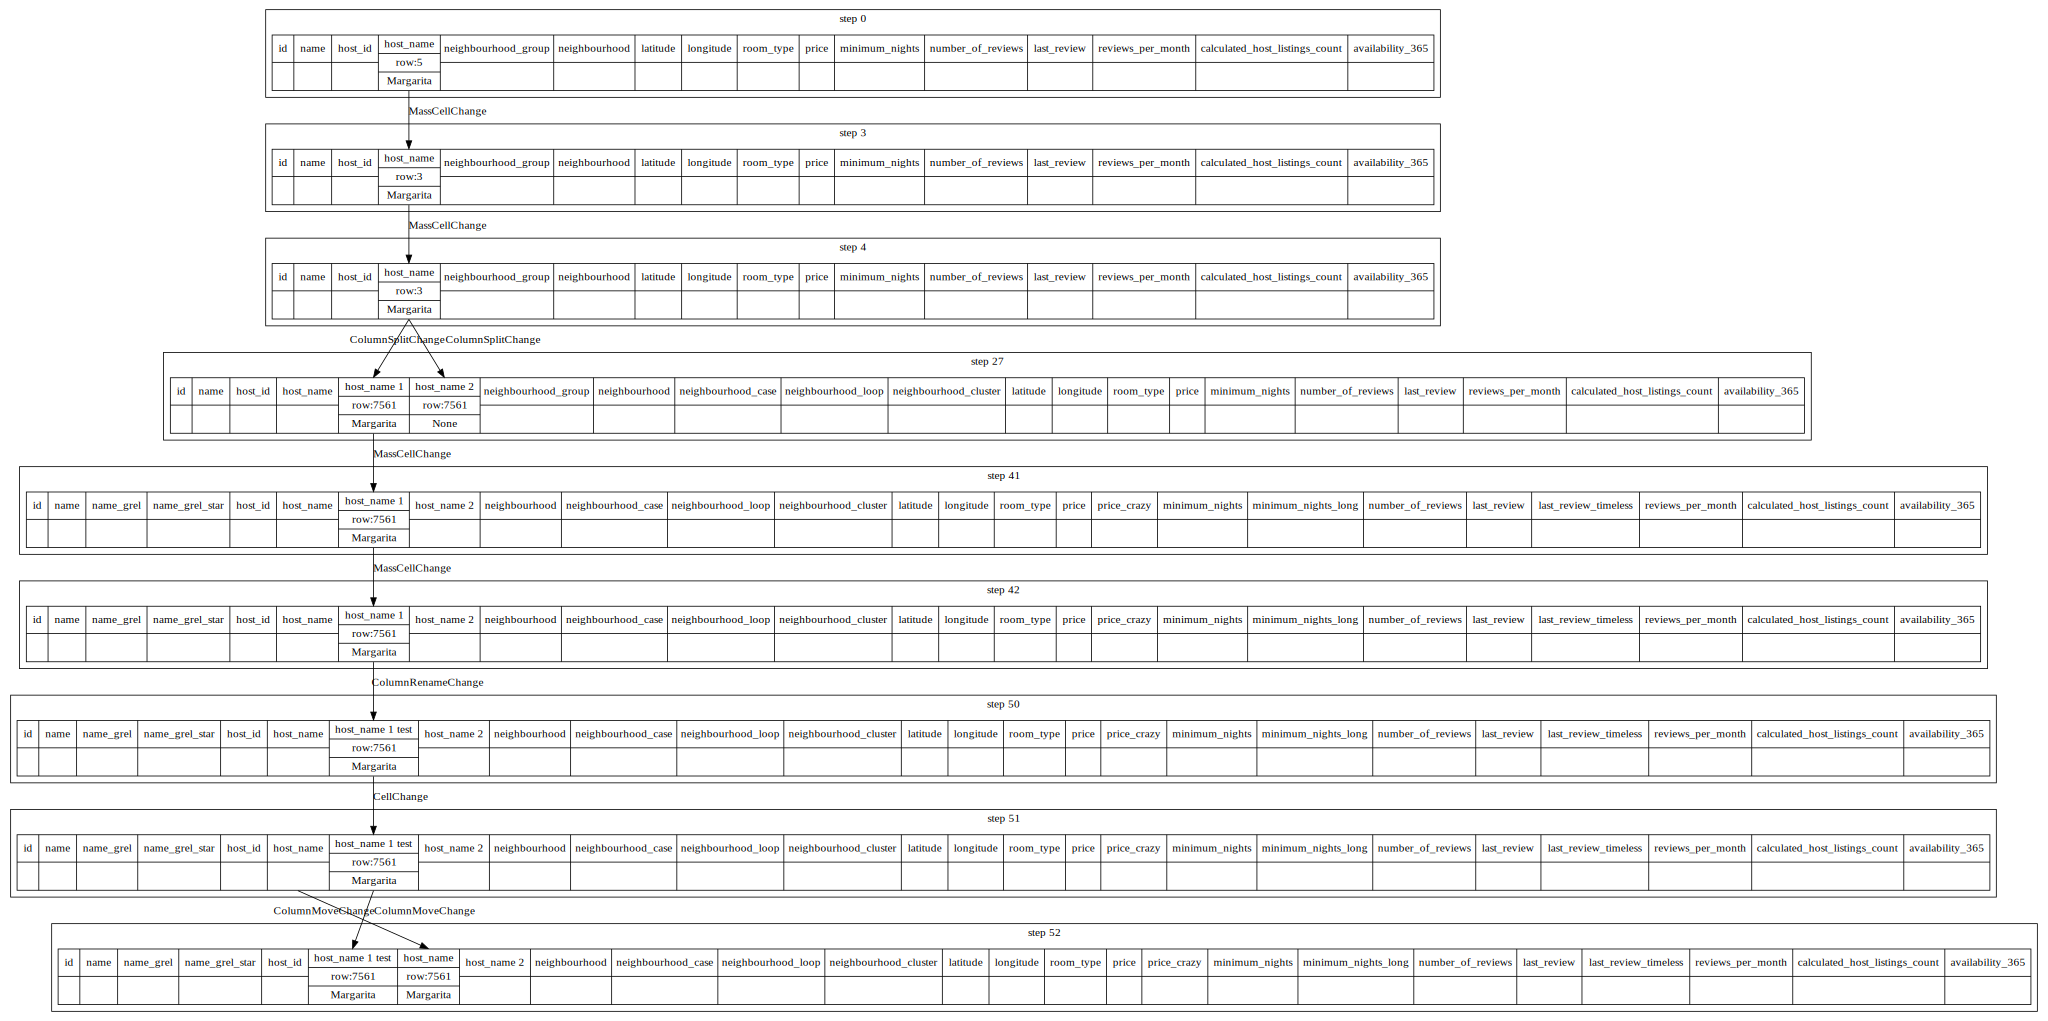

In [471]:
xx[1]

In [464]:
xx[0]

[(0,
  3,
  3,
  3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  0      0        58         138               -1  Margarita       5       3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  3      3        55         138               -1  Margarita       5       3),
 (3,
  4,
  3,
  3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  3      3        55         138               -1  Margarita       5       3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  4      4        54         138               -1  Margarita       5       3),
 (4,
  27,
  3,
  20,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  4      4        54         138               -1  Margarita       5       3,
      state  state_id  content_id  prev_content_id value_text  row_id  col_id
  27     27        31         155               -1       None       5      20),
 (4

In [465]:
print(xx[1].source)


        digraph {
        rankdir=TB;
        node [ shape=record ];
        splines="line";
        
                subgraph cluster_0 {
                    label="step 0";

                    struct0[
                        label = "{<port0>id}|{<port1>name}|{<port2>host_id}|{<port3>host_name|row:5|<port3>Margarita}|{<port4>neighbourhood_group}|{<port5>neighbourhood}|{<port6>latitude}|{<port7>longitude}|{<port8>room_type}|{<port9>price}|{<port10>minimum_nights}|{<port11>number_of_reviews}|{<port12>last_review}|{<port13>reviews_per_month}|{<port14>calculated_host_listings_count}|{<port15>availability_365}";
                    ];
                }
                
                subgraph cluster_3 {
                    label="step 3";
                    struct3[
                        label = "{<port0>id}|{<port1>name}|{<port2>host_id}|{<port3>host_name|row:3|<port3>Margarita}|{<port4>neighbourhood_group}|{<port5>neighbourhood}|{<port6>latitude}|{<port7>longitude}|{<port8>room_

In [288]:
pd.DataFrame(xx[0])

,0,1,2,3,4,5
0,0,5,5,5,state state_id content_id prev_content_i...,state state_id content_id prev_content_i...
1,5,6,5,5,state state_id content_id prev_content_i...,state state_id content_id prev_content_i...
2,6,10,6,6,state state_id content_id prev_content_i...,state state_id content_id prev_content_...
3,10,18,5,16,state state_id content_id prev_content_...,state state_id content_id prev_content_...
4,18,52,5,5,state state_id content_id prev_content_...,state state_id content_id prev_content_...
5,18,52,6,6,state state_id content_id prev_content_...,state state_id content_id prev_content_...


In [289]:
xx[0]

[(0,
  5,
  5,
  5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  0      0        58         140               -1  Bridgeport       5       5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  5      5        53         140               -1  Bridgeport       5       5),
 (5,
  6,
  5,
  5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  5      5        53         140               -1  Bridgeport       5       5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  6      6        52         140               -1  Bridgeport       5       5),
 (6,
  10,
  6,
  6,
     state  state_id  content_id  prev_content_id   value_text  row_id  col_id
  6      6        52      281300              141  41.82704745       5       6,
      state  state_id  content_id  prev_content_id   value_text  row_id  col_id
  10     10        48         141               -1  41.82704745       

In [136]:
#orpe.get_state_dependency(55)
orpe.get_column_dependency(6).state.tolist()
orpe.get_state_dependency(orpe.get_column_dependency(6).state.tolist())


,state,command,dep_state,dep_command,input_column,output_column
0,10,MassCellChange,10,MassCellChange,6,6
1,52,ColumnMoveChange,5,MassCellChange,5,5
2,52,ColumnMoveChange,6,MassCellChange,5,5
3,52,ColumnMoveChange,10,MassCellChange,6,6
4,52,ColumnMoveChange,18,ColumnAdditionChange,5,5
5,52,ColumnMoveChange,28,ColumnRemovalChange,6,6
6,52,ColumnMoveChange,52,ColumnMoveChange,5,5
7,52,ColumnMoveChange,52,ColumnMoveChange,6,6


In [152]:
col=6        
col_state_dep = orpe.get_column_dependency(col).state.tolist()
state_dep = orpe.get_state_dependency(col_state_dep)
state_dep.dep_state.unique()
state_dep[["input_column","output_column"]].values.flatten()

array([6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 6, 6])

In [163]:
xx = state_dep[["input_column","output_column"]].values.flatten()
{x:x for x in xx}

{6: 6, 5: 5}

# Changes at state

In [10]:
@interact
def interactive_form(start_state=range(0,num_state),end_state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_changes_each_state(range(start_state,end_state+1))
#orpe.get_changes_each_state(2)

interactive(children=(Dropdown(description='start_state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

# Column Schema changes at state

In [11]:
@interact
def interactive_form(start_state=range(0,num_state),end_state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_col_at_state_order(range(start_state,end_state+1))

#orpe.get_col_at_state_order(range(2,5))

interactive(children=(Dropdown(description='start_state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

# Row order at state

In [12]:
@interact
def interactive_form(state_id=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_row_at_state_order(state_id)

#orpe.get_row_at_state_order(5) 

interactive(children=(Dropdown(description='state_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

# Cell History

In [13]:
@interact
def interactive_form(col="0",row="3"):
    #return df.loc[df[column] > x]
    return orpe.get_cell_history(int(row),int(col))


interactive(children=(Text(value='0', description='col'), Text(value='3', description='row'), Output()), _dom_…

# Snapshot at state

In [14]:
@interact
def interactive_form(state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_snapshot_at_state(state)


interactive(children=(Dropdown(description='state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

# Graphviz

In [15]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()
dot2 = Digraph()

In [71]:
orpe.get_number_of_state().num_state[0]

58

In [74]:
temp

'\ndigraph {{\n  rankdir=TB;\n  node [ shape=record ];\n\n    struct0 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct1 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct2 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct3 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_p

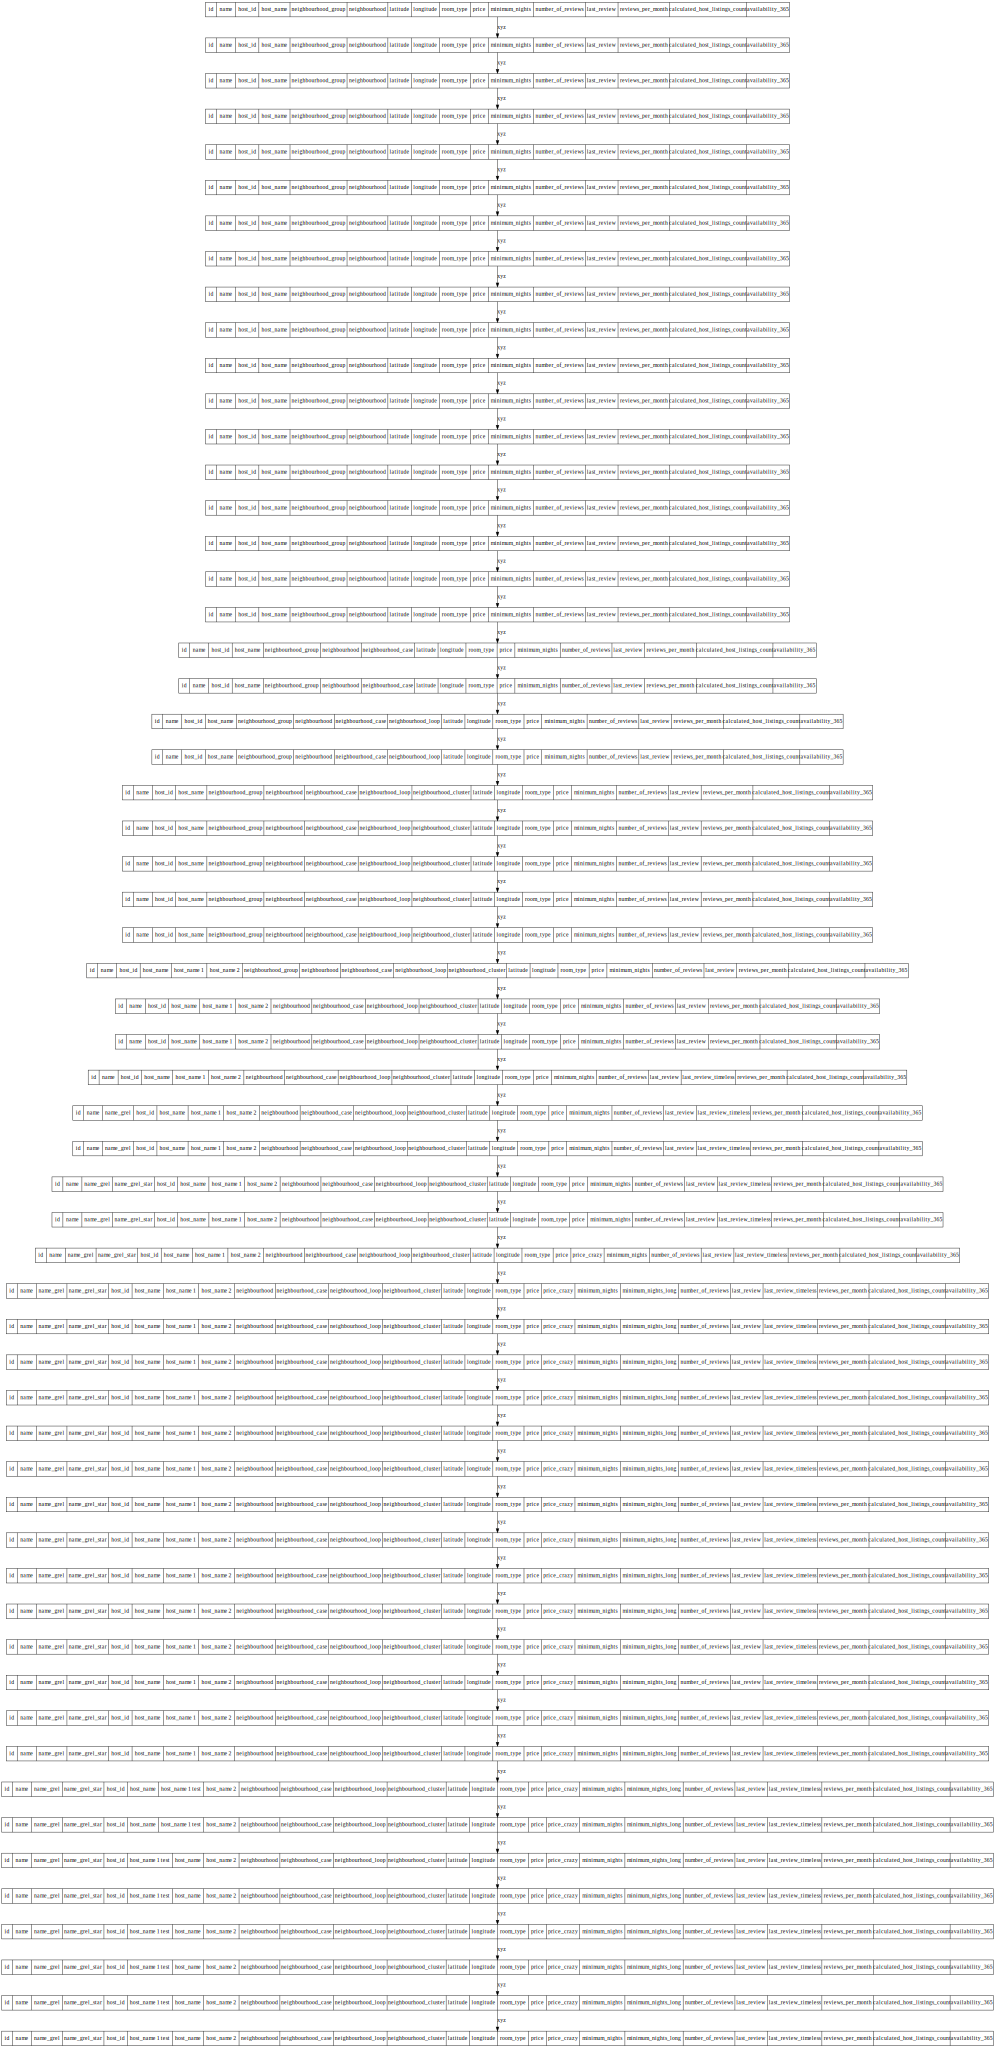

In [92]:
from graphviz import Source
temp = """
digraph {
  rankdir=TB;
  node [ shape=record ];
"""
s_coll=""
s_port=""
for s in range(0,orpe.get_number_of_state().num_state[0]):    
    s_coll+="""
    struct{s_num}[
        label = "{s_label}";
    ];
    """.format(s_num=s,s_label="|".join(orpe.get_col_at_state_order(s).col_name.tolist()))
    if s>0:
        s_port+="""
        struct{}:port1 -> struct{}:port2 [ label="xyz" ];
        """.format(s-1,s)

temp+=s_coll
temp+="""
{}
}}
""".format(s_port)
s = Source(temp)
#s.view()
s

In [ ]:
digraph {
  rankdir=LR;
  node [ shape=record ];

  struct1 [
      label = "a|b|<port1>c";
  ];
  
  struct2 [
      label = "a|{<port2>b1|b2}|c";
  ];
  
  struct1:port1 -> struct2:port2 [ label="xyz" ];
}

In [91]:
"|".join(orpe.get_col_at_state_order(0).col_name.tolist())

'id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365'

In [86]:
print(temp)


digraph {{
  rankdir=TB;
  node [ shape=record ];

    struct0[
        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";
    ];
    
    struct1[
        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";
    ];
    

        struct1:port1 -> struct0:port2 [ label="xyz" ];
        
}



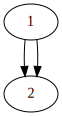

In [30]:
dot.subgraph(dot2)
dot.node('1')
dot.node('2')

# Add edge between 1 and 2
dot.edges(['12'])
dot2.node('1')
dot2.node('2')

# Add edge between 1 and 2
dot2.edges(['12'])
dot
dot2

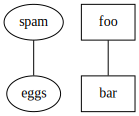

In [36]:
from graphviz import Graph

p = Graph(name='parent')
p.edge('spam', 'eggs')

c = Graph(name='child', node_attr={'shape': 'box'})
c.edge('foo', 'bar')

p.subgraph(c)
p

In [28]:
from graphviz import Source
temp = """
digraph G {

  subgraph cluster_0 {
    style=filled;
    color=lightgrey;
    node [style=filled,color=white];
    a0 -> a1 -> a2 -> a3;
    label = "process #1";
  }

  subgraph cluster_1 {
    node [style=filled];
    b0 -> b1 -> b2 -> b3;
    label = "process #2";
    color=blue
  }
  start -> a0;
  start -> b0;
  a1 -> b3;
  b2 -> a3;
  a3 -> a0;
  a3 -> end;
  b3 -> end;

  start [shape=Mdiamond];
  end [shape=Msquare];
}
"""
s = Source(temp, filename="test.gv", format="png")
s.view()


'test.gv.png'

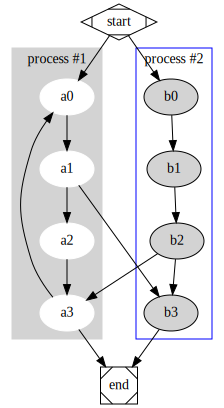

In [29]:
s

In [ ]:
s.

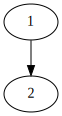

In [15]:
# Add nodes 1 and 2
dot.node('1')
dot.node('2')

# Add edge between 1 and 2
dot.edges(['12'])
dot

In [177]:
orpe.get_col_at_state_order(1)

,state,col_id,col_name,prev_col_id,level
0,1,0,Title,-1,0
1,1,1,Author,0,1
2,1,2,Date,1,2


In [154]:
@interact
def interactive_form(x=range(0,num_state),y=range(0,num_state)):
    #return df.loc[df[column] > x]
    return orpe.get_column_at_state(range(x,y+1))


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [108]:
tt = orpe.get_snapshot_at_state(0)

In [109]:
tt

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30041063,(Quiet & Affordable Private BDR near UOC),225773707,LaShun test,None,Woodlawn,41.77712429,-87.59471115,Private room,25,1,0,None,None,1,173
1,29960994,(Feel cozy in chicago),225262670,Karla,None,Edgewater,41.98536071,-87.66898893,Private room,70,2,0,None,None,1,179
2,29946929,(Cozy 2 Bedroom Apartment in the Heart of Chic...,225157895,Frankie,None,Lower West Side,41.85198185,-87.67767597,Entire home/apt,79,1,0,None,None,1,62
3,29940545,(Beautiful 7Br 6200 sf Brick & Steel Custom Ma...,225106605,Neda,None,Bridgeport,41.84452795,-87.6558587,Entire home/apt,300,2,0,None,None,1,355
4,29936021,"(Convenient, Beautiful, Spacious 2Br/2Ba Condo)",225076770,J,None,Mckinley Park,41.8296729,-87.67826309,Entire home/apt,70,1,0,None,None,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587,10610,(3 Comforts of Cooperative Living),2140,Lois And Ed,None,hyde park,41.79708495,-87.59194894,Private room,35,2,31,2018-07-29T00:00:00Z,0.63,5,179
7588,3907071,(2 A Walk in Hyde Park),2140,Lois And Ed,None,hyde park,41.79554928,-87.59174205,Private room,37,2,45,2018-09-28T00:00:00Z,0.91,5,232
7589,3983057,(4 Cooperative Living in Hyde Park),2140,Lois And Ed,None,hyde park,41.79507237,-87.59332266,Private room,40,2,38,2018-09-16T00:00:00Z,0.88,5,333
7590,3984079,(5 Sabbatical in Hyde Park),2140,Lois And Ed,None,hyde park,41.79718187,-87.59378733,Entire home/apt,150,2,10,2018-07-23T00:00:00Z,0.31,5,55


In [14]:
orpe.get_cell_history(3,2)

,state,state_id,content_id,prev_content_id,value_text,row_id,col_id
0,0,58,288897,83,225106605,3,2
1,1,57,288897,83,225106605,3,2
2,2,56,288897,83,225106605,3,2
3,3,55,288897,83,225106605,3,2
4,4,54,288897,83,225106605,3,2
5,5,53,288897,83,225106605,3,2
6,6,52,288897,83,225106605,3,2
7,7,51,288897,83,225106605,3,2
8,8,50,288897,83,225106605,3,2
9,9,49,83,-1,225106605,3,2


In [4]:
orpe.get_column_at_state(1)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,1,57,0,0,id,-1,-1
1,1,57,1,1,name,0,-1
2,1,57,2,22,name_grel,1,-1
3,1,57,3,23,name_grel_star,22,-1
4,1,57,9,16,neighbourhood_case,5,-1
5,1,57,10,17,neighbourhood_loop,16,-1
6,1,57,11,26,test_combine,17,-1
7,1,57,14,7,longitude,6,-1
8,1,57,15,8,room_type,7,-1
9,1,57,16,9,price,8,-1


In [6]:
orpe.get_col_at_state_order(0)

,state,col_id,col_name,prev_col_id,level
0,0,0,id,-1,0
1,0,1,name,0,1
2,0,22,name_grel,1,2
3,0,2,host_id,1,2
4,0,23,name_grel_star,22,3
5,0,3,host_name,2,3
6,0,4,neighbourhood_group,3,4
7,0,5,neighbourhood,4,5
8,0,16,neighbourhood_case,5,6
9,0,6,latitude,5,6


In [6]:
orpe.get_col_idx_to_logic(8,1)

1

In [7]:
orpe.get_col_logic_to_idx(8,2)

22

In [3]:
xx = orpe.get_row_at_state(1)
xx

In [13]:
orpe.get_row_at_state_order(0)

,state,state_id,row_id,prev_row_id,level
0,58,0,0,-1,0
1,58,0,1,0,1
2,58,0,2,1,2
3,58,0,3,2,3
4,58,0,4,3,4
...,...,...,...,...,...
7587,58,0,7587,7586,7587
7588,58,0,7588,7587,7588
7589,58,0,7589,7588,7589
7590,58,0,7590,7589,7590


In [175]:
orpe.get_row_logic_to_idx(4,2)

3

In [176]:
orpe.get_row_idx_to_logic(4,3)

2

In [177]:
orpe.get_values_at_state(0)

,state,state_id,content_id,prev_content_id,value_text,row_id,col_id
0,0,9,0,-1,Against Method,0,0
1,0,9,1,-1,"Feyerabend, P.",0,1
2,0,9,3,-1,Feyerabend,0,3
3,0,9,4,-1,None,0,4
4,0,9,5,-1,Changing Order,1,0
5,0,9,6,-1,"Collins, H.M.",1,1
6,0,9,8,-1,Collins,1,3
7,0,9,9,-1,None,1,4
8,0,9,10,-1,Exceeding Our Grasp,2,0
9,0,9,13,-1,Stanford,2,3


In [164]:
xx.row_pos_id.tolist().index(4)

2

In [22]:
list(orpe.cursor.execute("select * from col_each_state where state=8"))
names = list(map(lambda x: x[0], orpe.cursor.description))
names

['state',
 'state_id',
 'col_schema_id',
 'col_id',
 'col_name',
 'prev_col_id',
 'prev_col_schema_id']

In [21]:
xx = orpe.cursor.execute("select * from col_each_state where state=8")

['state',
 'state_id',
 'col_schema_id',
 'col_id',
 'col_name',
 'prev_col_id',
 'prev_col_schema_id']

In [16]:
orpe.get_column_at_state(5)

[(5, 4, 0, 0, 'Title', -1, -1),
 (5, 4, 8, 2, 'Date', 1, 1),
 (5, 4, 9, 1, 'Author', 0, 2)]